Import Library

In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import nltk
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt


Set Seed

In [2]:
np.random.seed(500)

Load Data

In [3]:
def muat_data(Corpus):
    Dataset = Corpus[['text_cleaning','sentimen']]
    Dataset.head()
    return Dataset

Preprocessing Text

In [4]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocessing_teks(Corpus):
    # Mengubah semua teks menjadi huruf kecil
    Corpus['teks'] = Corpus['teks'].str.lower()

    # Tokenisasi
    Corpus['teks'] = Corpus['teks'].apply(word_tokenize)

    # Inisialisasi lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Menghapus stop words dan melakukan lemmatization
    stop_words = set(stopwords.words('indonesian'))

    def preprocess_text(tokens):
        return [
            lemmatizer.lemmatize(word) for word in tokens 
            if word.isalpha() and word not in stop_words
        ]

    Corpus['teks'] = Corpus['teks'].apply(preprocess_text)

    # Menggabungkan kembali token menjadi string
    Corpus['teks'] = Corpus['teks'].apply(lambda x: ' '.join(x))

    return Corpus  # Mengembalikan DataFrame yang telah diproses

Visualisasi Pie Chart Proporsi Data Label

In [5]:
def viz(Dataset):
    # Menghitung distribusi label
    label_distribution = Dataset['sentimen'].value_counts().reset_index()
    label_distribution.columns = ['sentimen', 'jumlah']

    # Mapping label untuk visualisasi
    label_mapping = {0: 'negatif', 1: 'netral', 2: 'positif'}
    label_distribution['sentimen'] = label_distribution['sentimen'].map(label_mapping)

    # Visualisasi sebaran label menggunakan pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(label_distribution['jumlah'], labels=label_distribution['sentimen'], autopct='%1.1f%%', colors=sns.color_palette('viridis', len(label_distribution)))
    plt.title('Sebaran Data Label Sentimen')
    plt.show()


Visualisasi WordCloud

In [6]:
from wordcloud import WordCloud

def buat_wordcloud(text):
    # Buat word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Tampilkan word cloud
    plt.figure(figsize=(10, 5), dpi=300)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Tidak menampilkan sumbu
    plt.show()

Mempersiapkan Data Teks

In [7]:
def preparation_teks(Dataset):
    # Membuat peta kode label ke label asli
    label_mapping = dict(enumerate(Dataset['sentimen'].astype('category').cat.categories))
    print(label_mapping)
        
    # Mengganti nama kolom
    Dataset = Dataset.rename(columns={
        'text_cleaning': 'teks'
    })
    # Mengubah isian kolom sentimen menjadi bertipe integer untuk masing-masing kategori
    Dataset['sentimen'] = Dataset['sentimen'].astype('category').cat.codes
    # Menghitung sebaran data label di kolom sentimen
    viz(Dataset)
    return Dataset, label_mapping

Cleaning Teks

In [8]:
import re
# Fungsi untuk membersihkan spasi lebih dari satu
def clean_text(text):
    if isinstance(text, str):  # Memastikan bahwa input adalah string
        # Mengganti spasi lebih dari satu dengan satu spasi
        cleaned_text = re.sub(r'\s+', ' ', text)
        return cleaned_text.strip()
    return text  # Kembalikan teks tanpa perubahan jika bukan string

Pendefinisian Fungsi untuk Augmentasi Data Teks dengan Back Translation

In [9]:
from deep_translator import GoogleTranslator
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

def translate_augmentation(text, src='id', dest='id', temps=['en', 'zh-CN', 'es' ,'ja']):
    translated_texts = []
    for temp in temps:
        translator = GoogleTranslator(source=src, target=temp)
        translated_text = translator.translate(text)
        translator_back = GoogleTranslator(source=temp, target=dest)
        back_translated_text = translator_back.translate(translated_text)
        translated_texts.append(back_translated_text)
    return translated_texts

Augmentasi Data Teks

In [10]:
def back_translation(Dataset):
    # Splitting the data into train and test sets with stratification
    train_data, test_data = train_test_split(Dataset, test_size=0.2, random_state=42, stratify=Dataset['sentimen'])

    # Augmenting only the training data for neutral sentiment (sentimen == 1)
    df_train = train_data.dropna()
    df_train_neutral = df_train[df_train['sentimen'] == 1].copy()
    
    # Apply back translation
    df_train_neutral['teks_augmented'] = df_train_neutral['teks'].apply(
        lambda x: translate_augmentation(x)
    )

    # Flattening the list of augmented texts and repeating corresponding sentiment labels
    augmented_data = pd.DataFrame({
        'teks': sum(df_train_neutral['teks_augmented'].tolist(), []),
        'sentimen': 1
    })
    
    # Concatenate the original training data with the augmented data
    train_data_baru = pd.concat([df_train, augmented_data]).drop_duplicates(subset=['teks', 'sentimen'])

    # Optionally visualize and save the augmented training data
    all_text = ' '.join(train_data_baru['teks'])
    buat_wordcloud(all_text)
    viz(train_data_baru)
    train_data_baru.to_csv("HasilAugmentasi_Train.csv")
    test_data.to_csv("Data_Test.csv")
    # Menggabungkan kedua DataFrame
    data_gabungan = pd.concat([train_data_baru, test_data], ignore_index=True)

    # Melakukan shuffle pada data gabungan
    data_acak = data_gabungan.sample(frac=1).reset_index(drop=True)
    # Text Vectorization
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(data_acak['teks']).toarray()

    # Label Encoding
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data_acak['sentimen'])

    return X, y


SVM

In [11]:
import optuna
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score
import numpy as np
import logging

def model_svm(X, y, cv=5):
    print("===========Support Vector Machine Classifier============")
    # Nonaktifkan logging optuna
    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):
        # Tuning hyperparameter untuk SVM dengan kernel linear
        C = trial.suggest_loguniform('C', 1e-5, 10.0)

        # Buat model SVM Linear
        model = SVC(kernel='linear', C=C)

        # Melakukan cross-validation dan mengembalikan rata-rata akurasi
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        return np.mean(scores)

    # Membuat dan menjalankan Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # Menjalankan 100 percobaan

    # Mendapatkan hyperparameter terbaik
    best_C = study.best_params['C']

    # Buat model SVM dengan kernel linear dan hyperparameter terbaik
    best_model = SVC(kernel='linear', C=best_C)

    # Prediksi dengan cross-validation
    y_pred = cross_val_predict(best_model, X, y, cv=cv)

    # Evaluasi model
    accuracy = accuracy_score(y, y_pred)
    confusion = confusion_matrix(y, y_pred)
    classification_rep = classification_report(y, y_pred)

    # Menampilkan hasil evaluasi
    print(f"Akurasi: {accuracy:.2f}")
    print("Matriks Kebingungan:")
    print(confusion)
    print("Laporan Klasifikasi:")
    print(classification_rep)

    # Evaluasi dengan cross-validation pada model terbaik
    cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy')
    print(f"\nCross-Validation Akurasi: {cv_scores}")
    print(f"Rata-rata Cross-Validation Akurasi: {np.mean(cv_scores):.2f}")


Ridge

In [12]:
import optuna
from sklearn.linear_model import RidgeClassifier

def model_ridge(X, y, cv=5):
    print("===========Ridge Classifier============")
    # Nonaktifkan logging optuna
    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):
        # Tuning hyperparameter untuk RidgeClassifier
        alpha = trial.suggest_loguniform('alpha', 1e-5, 10.0)

        # Buat model RidgeClassifier
        model = RidgeClassifier(alpha=alpha)

        # Melakukan cross-validation dan mengembalikan rata-rata akurasi
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        return np.mean(scores)

    # Membuat dan menjalankan Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # Menjalankan 100 percobaan

    # Mendapatkan hyperparameter terbaik
    best_alpha = study.best_params['alpha']

    # Buat model RidgeClassifier dengan hyperparameter terbaik
    best_model = RidgeClassifier(alpha=best_alpha)

    # Lakukan prediksi menggunakan cross-validation
    y_pred = cross_val_predict(best_model, X, y, cv=cv)

    # Evaluasi model
    accuracy = accuracy_score(y, y_pred)
    confusion = confusion_matrix(y, y_pred)
    classification_rep = classification_report(y, y_pred)

    # Menampilkan hasil evaluasi
    print(f"Akurasi: {accuracy:.2f}")
    print("Matriks Kebingungan:")
    print(confusion)
    print("Laporan Klasifikasi:")
    print(classification_rep)

    # Evaluasi dengan cross-validation pada model terbaik
    cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy')
    print(f"\nCross-Validation Akurasi: {cv_scores}")
    print(f"Rata-rata Cross-Validation Akurasi: {np.mean(cv_scores):.2f}")


Rocchio Algorithm

In [13]:
import optuna
from sklearn.neighbors import NearestCentroid

def model_rocchio(X, y, cv=5):
    print("===========Rocchio Algorithm============")
    # Nonaktifkan logging optuna
    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):
        # Tuning hyperparameter untuk NearestCentroid (implementasi Rocchio)
        metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])

        # Buat model NearestCentroid tanpa shrink_threshold
        model = NearestCentroid(metric=metric)

        # Melakukan cross-validation dan mengembalikan rata-rata akurasi
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        return np.mean(scores)

    # Membuat dan menjalankan Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # Menjalankan 100 percobaan

    # Mendapatkan hyperparameter terbaik
    best_params = study.best_params
    best_metric = best_params['metric']

    # Buat model NearestCentroid dengan hyperparameter terbaik
    best_model = NearestCentroid(metric=best_metric)

    # Lakukan prediksi menggunakan cross-validation
    y_pred = cross_val_predict(best_model, X, y, cv=cv)

    # Evaluasi model
    accuracy = accuracy_score(y, y_pred)
    confusion = confusion_matrix(y, y_pred)
    classification_rep = classification_report(y, y_pred)

    # Menampilkan hasil evaluasi
    print(f"Akurasi: {accuracy:.2f}")
    print("Matriks Kebingungan:")
    print(confusion)
    print("Laporan Klasifikasi:")
    print(classification_rep)

    # Evaluasi dengan cross-validation pada model terbaik
    cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy')
    print(f"\nCross-Validation Akurasi: {cv_scores}")
    print(f"Rata-rata Cross-Validation Akurasi: {np.mean(cv_scores):.2f}")


Multinomial Naive Bayes

In [14]:
import optuna
from sklearn.naive_bayes import MultinomialNB

def model_multinomial(X, y, cv=5):
    print("===========Multinomial Naive Bayes============")
    # Nonaktifkan logging optuna
    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):
        # Tuning hyperparameter untuk MultinomialNB
        alpha = trial.suggest_loguniform('alpha', 1e-5, 10.0)  # smoothing parameter

        # Buat model MultinomialNB
        model = MultinomialNB(alpha=alpha)

        # Melakukan cross-validation dan mengembalikan rata-rata akurasi
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        return np.mean(scores)

    # Membuat dan menjalankan Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # Menjalankan 100 percobaan

    # Mendapatkan hyperparameter terbaik
    best_alpha = study.best_params['alpha']

    # Buat model MultinomialNB dengan hyperparameter terbaik
    best_model = MultinomialNB(alpha=best_alpha)

    # Lakukan prediksi menggunakan cross-validation
    y_pred = cross_val_predict(best_model, X, y, cv=cv)

    # Evaluasi model
    accuracy = accuracy_score(y, y_pred)
    confusion = confusion_matrix(y, y_pred)
    classification_rep = classification_report(y, y_pred)

    # Menampilkan hasil evaluasi
    print(f"Akurasi: {accuracy:.2f}")
    print("Matriks Kebingungan:")
    print(confusion)
    print("Laporan Klasifikasi:")
    print(classification_rep)

    # Evaluasi dengan cross-validation pada model terbaik
    cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy')
    print(f"\nCross-Validation Akurasi: {cv_scores}")
    print(f"Rata-rata Cross-Validation Akurasi: {np.mean(cv_scores):.2f}")


KNN

In [15]:
import optuna
from sklearn.neighbors import KNeighborsClassifier

def model_knn(X, y, cv=5):
    print("===========K-Nearest Neighbour============")
    # Nonaktifkan logging optuna
    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):
        # Tuning hyperparameter untuk KNeighborsClassifier
        n_neighbors = trial.suggest_int('n_neighbors', 1, 50)  # Jumlah tetangga
        weights = trial.suggest_categorical('weights', ['uniform', 'distance'])  # Jenis pembobotan
        algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])  # Algoritma pencarian

        # Buat model KNeighborsClassifier
        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)

        # Melakukan cross-validation dan mengembalikan rata-rata akurasi
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        return np.mean(scores)

    # Membuat dan menjalankan Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # Menjalankan 100 percobaan

    # Mendapatkan hyperparameter terbaik
    best_params = study.best_params
    best_n_neighbors = best_params['n_neighbors']
    best_weights = best_params['weights']
    best_algorithm = best_params['algorithm']

    # Buat model KNeighborsClassifier dengan hyperparameter terbaik
    best_model = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, algorithm=best_algorithm)

    # Lakukan prediksi menggunakan cross-validation
    y_pred = cross_val_predict(best_model, X, y, cv=cv)

    # Evaluasi model
    accuracy = accuracy_score(y, y_pred)
    confusion = confusion_matrix(y, y_pred)
    classification_rep = classification_report(y, y_pred)

    # Menampilkan hasil evaluasi
    print(f"Akurasi: {accuracy:.2f}")
    print("Matriks Kebingungan:")
    print(confusion)
    print("Laporan Klasifikasi:")
    print(classification_rep)

    # Evaluasi dengan cross-validation pada model terbaik
    cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy')
    print(f"\nCross-Validation Akurasi: {cv_scores}")
    print(f"Rata-rata Cross-Validation Akurasi: {np.mean(cv_scores):.2f}")


Regresi Logistic

In [16]:
import optuna
from sklearn.linear_model import LogisticRegression

def model_reglog(X, y, cv=5):
    print("===========Logistic Regression============")
    # Nonaktifkan logging optuna
    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):
        # Tuning hyperparameter untuk LogisticRegression
        C = trial.suggest_loguniform('C', 1e-5, 10.0)  # Parameter regularisasi
        solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'saga'])
        
        # Menentukan opsi multi_class berdasarkan solver
        if solver == 'liblinear':
            multi_class = 'ovr'
        else:
            multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial'])

        # Buat model LogisticRegression
        model = LogisticRegression(C=C, solver=solver, multi_class=multi_class, max_iter=1000)

        # Melakukan cross-validation (5-fold) dan mengembalikan rata-rata akurasi
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        return np.mean(scores)

    # Membuat dan menjalankan Optuna study
    study = optuna.create_study(direction='maximize')  # Kita ingin memaksimalkan akurasi
    study.optimize(objective, n_trials=100)  # Menjalankan 100 percobaan

    # Mendapatkan hyperparameter terbaik
    best_params = study.best_params
    best_C = best_params['C']
    best_solver = best_params['solver']
    best_multi_class = best_params['multi_class']

    # Buat model LogisticRegression dengan hyperparameter terbaik
    best_model = LogisticRegression(C=best_C, solver=best_solver, multi_class=best_multi_class, max_iter=1000)

    # Lakukan prediksi menggunakan cross-validation
    y_pred = cross_val_predict(best_model, X, y, cv=cv)

    # Evaluasi model
    accuracy = accuracy_score(y, y_pred)
    confusion = confusion_matrix(y, y_pred)
    classification_rep = classification_report(y, y_pred)

    # Menampilkan hasil evaluasi
    print(f"Akurasi: {accuracy:.2f}")
    print("Matriks Kebingungan:")
    print(confusion)
    print("Laporan Klasifikasi:")
    print(classification_rep)

    # Evaluasi dengan cross-validation pada model terbaik
    cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy')
    print(f"\nCross-Validation Akurasi: {cv_scores}")
    print(f"Rata-rata Cross-Validation Akurasi: {np.mean(cv_scores):.2f}")


Light Gradient Boosting Machine

In [17]:
import optuna
from lightgbm import LGBMClassifier

def model_lgbm(X, y, cv=5):
    print("===========LightGBM Classifier============")
    # Nonaktifkan logging optuna
    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):
        # Tuning hyperparameter untuk LGBM
        num_leaves = trial.suggest_int('num_leaves', 31, 128)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
        n_estimators = trial.suggest_int('n_estimators', 50, 500)
        max_depth = trial.suggest_int('max_depth', -1, 50)  # -1 means no limit

        # Buat model LGBM
        model = LGBMClassifier(
            num_leaves=num_leaves,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            verbose=0
        )

        # Melakukan cross-validation (5-fold) dan mengembalikan rata-rata akurasi
        scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        return np.mean(scores)

    # Membuat dan menjalankan Optuna study
    study = optuna.create_study(direction='maximize')  # Kita ingin memaksimalkan akurasi
    study.optimize(objective, n_trials=100)  # Menjalankan 100 percobaan

    # Mendapatkan hyperparameter terbaik
    best_params = study.best_params

    # Buat model LGBM dengan hyperparameter terbaik
    best_model = LGBMClassifier(
        num_leaves=best_params['num_leaves'],
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth']
    )

    # Lakukan prediksi menggunakan cross-validation
    y_pred = cross_val_predict(best_model, X, y, cv=cv)

    # Evaluasi model
    accuracy = accuracy_score(y, y_pred)
    confusion = confusion_matrix(y, y_pred)
    classification_rep = classification_report(y, y_pred)

    # Menampilkan hasil evaluasi
    print(f"Akurasi: {accuracy:.2f}")
    print("Matriks Kebingungan:")
    print(confusion)
    print("Laporan Klasifikasi:")
    print(classification_rep)

    # Evaluasi dengan cross-validation pada model terbaik
    cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy')
    print(f"\nCross-Validation Akurasi: {cv_scores}")
    print(f"Rata-rata Cross-Validation Akurasi: {np.mean(cv_scores):.2f}")


Main Program

{0: 'negatif', 1: 'netral', 2: 'positif'}


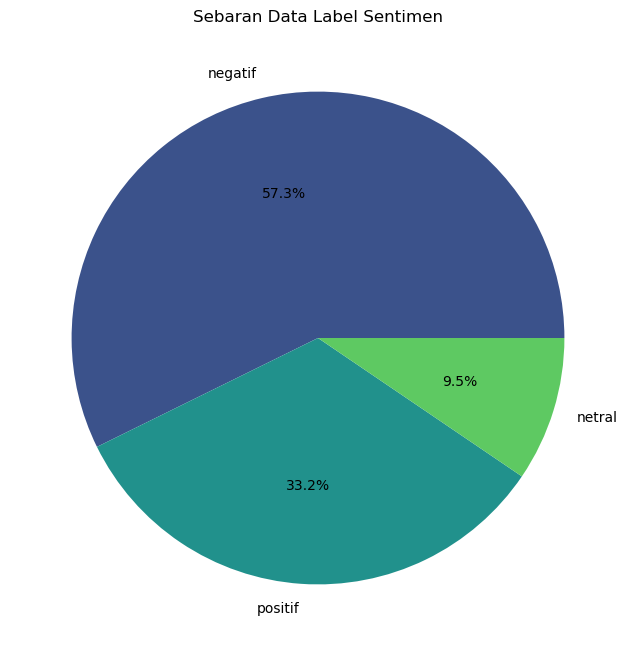

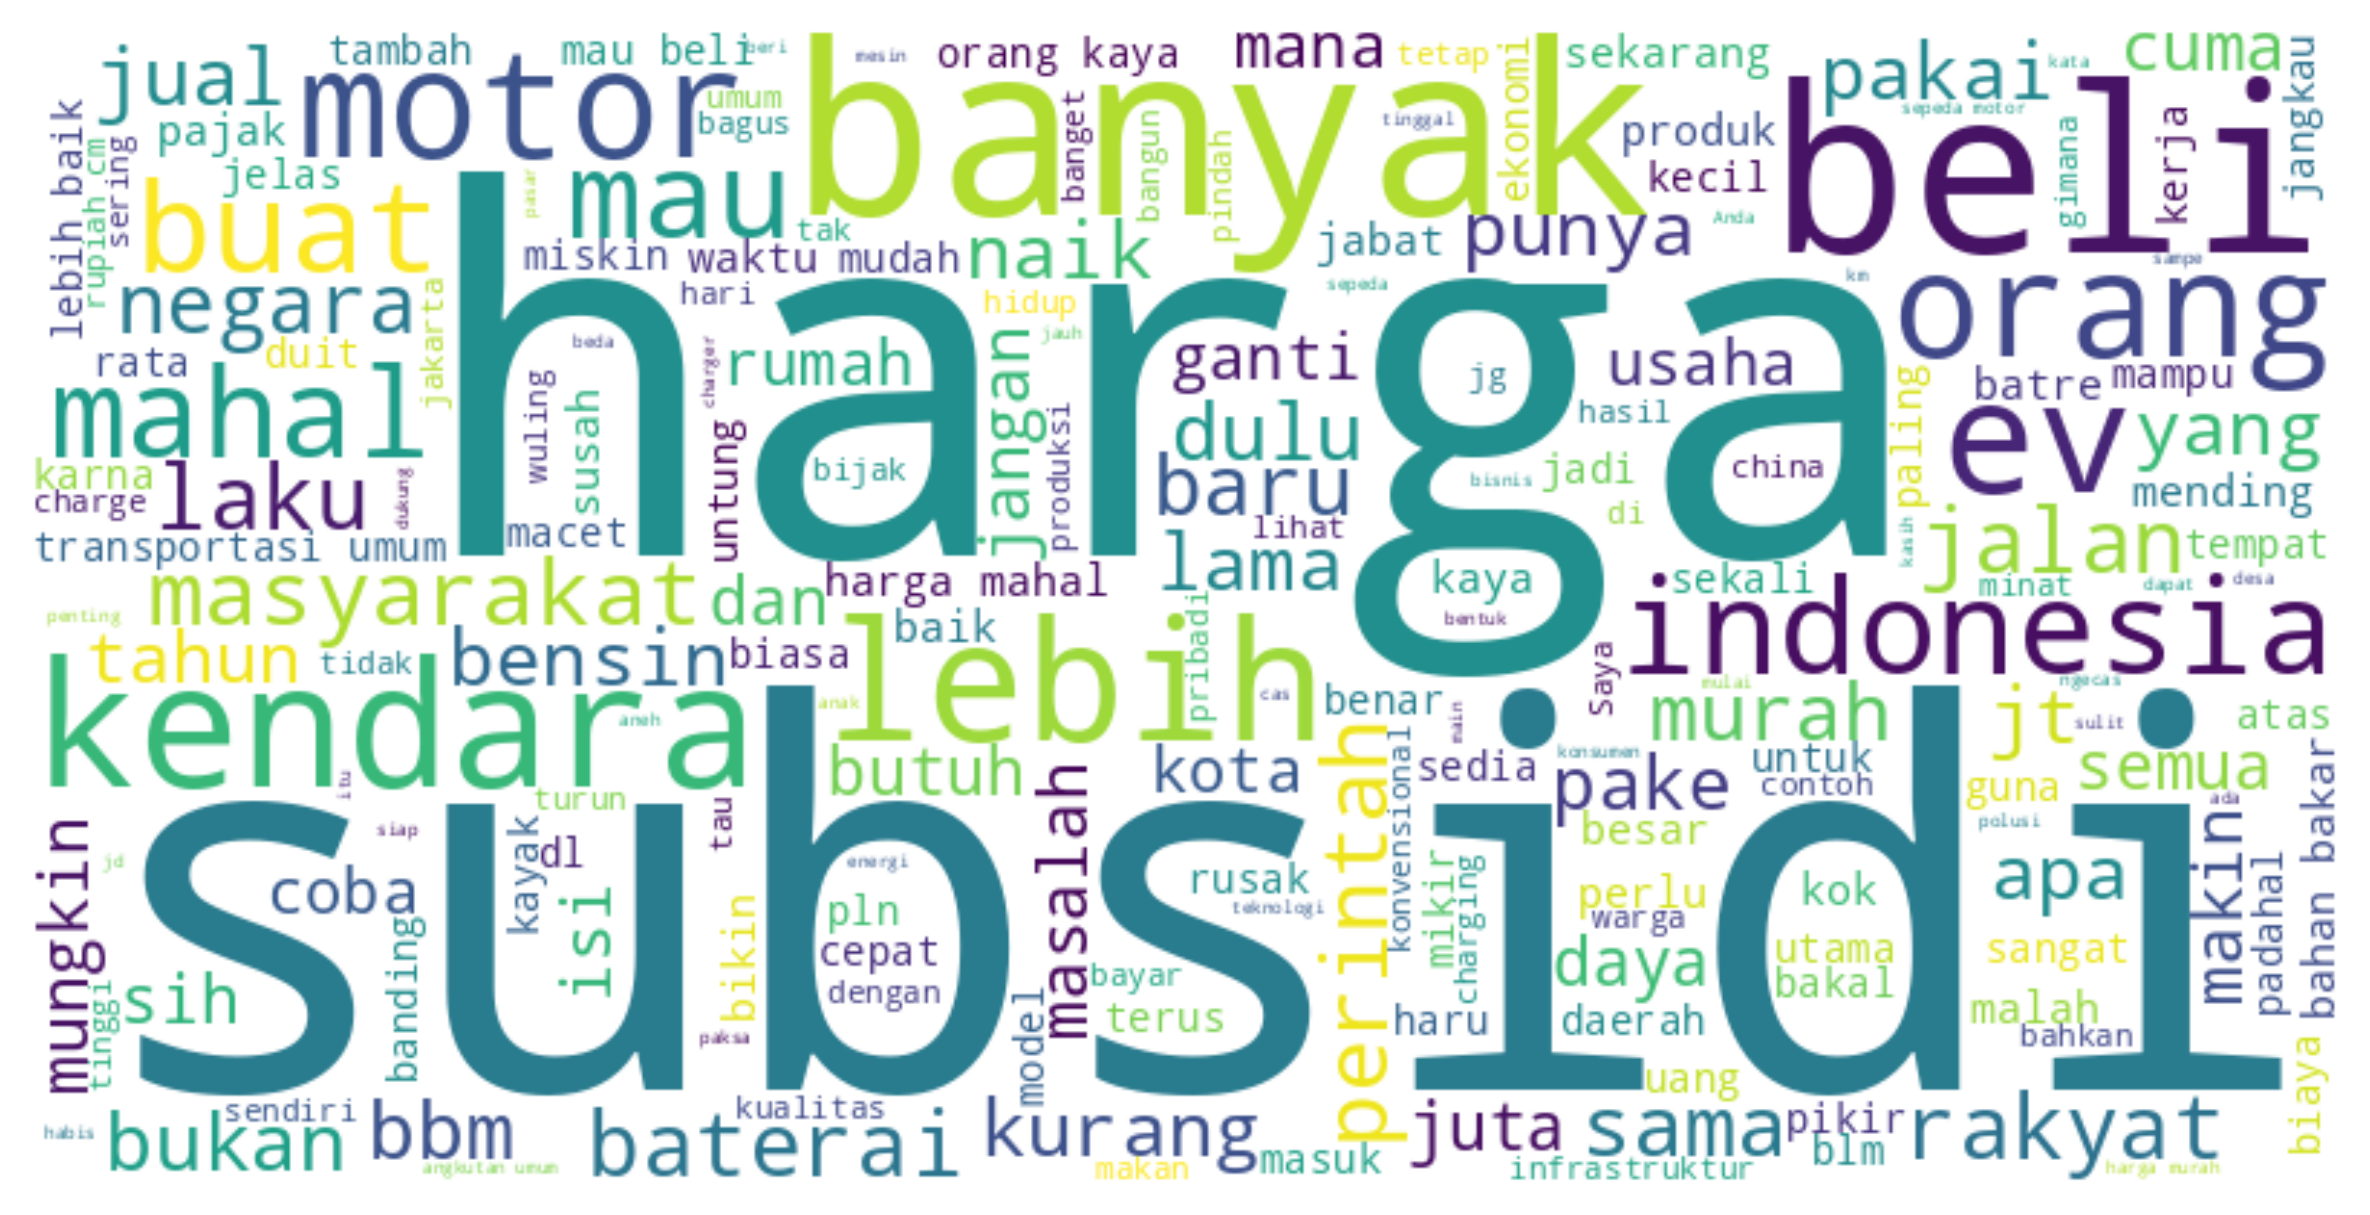

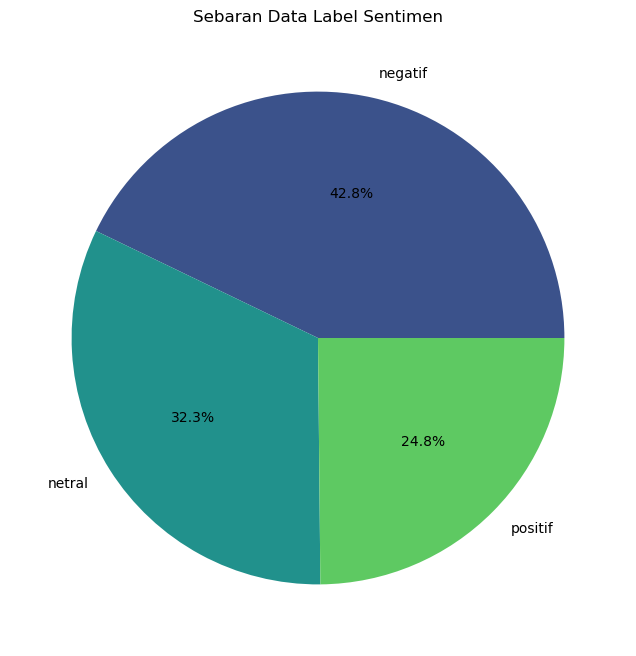

===========Support Vector Machine Classifier============


KeyboardInterrupt: 

In [18]:
Corpus = pd.read_csv("mobil_listrik.csv")
Dataset = muat_data(Corpus)
Dataset, label_mapping = preparation_teks(Dataset)

# Terapkan fungsi pada semua teks
Dataset['teks'] = Dataset['teks'].apply(clean_text)

# Dataset = back_translation(Dataset)
X, y = back_translation(Dataset)
# Cross Validation menggunakan Fold 10
cv = 10
model_svm(X, y, cv)
model_ridge(X, y, cv)
model_rocchio(X, y, cv)
model_multinomial(X, y, cv)
model_knn(X, y, cv)
model_reglog(X, y, cv)
model_lgbm(X, y, cv)


In [ ]:
import random
from nltk.corpus import wordnet

def synonym_replacement(text):
    words = text.split()
    new_words = []
    for word in words:
        synsets = wordnet.synsets(word, lang='ind')  # Mencari sinonim bahasa Indonesia
        if synsets:
            synonyms = set()
            for syn in synsets:
                for lemma in syn.lemmas():
                    synonyms.add(lemma.name())
            if synonyms:
                synonym = random.choice(list(synonyms))
                new_words.append(synonym)
            else:
                new_words.append(word)
        else:
            new_words.append(word)
    return ' '.join(new_words)

# Contoh penggunaan
text = "Saya pergi ke pasar untuk membeli buah."
augmented_text = synonym_replacement(text)
print(augmented_text)


Maine start inward fair untuk corrupt buah.


Model Prediksi

In [ ]:
# # Fungsi untuk memprediksi label
# def predict_label(input_text, model, vectorizer):
#     # Preprocess input text
#     # Mengubah teks menjadi huruf kecil
#     input_text = input_text.lower()
    
#     # Tokenisasi
#     tokens = word_tokenize(input_text)
    
#     # Menghapus stop words dan melakukan lemmatization
#     processed_tokens = [
#         lemmatizer.lemmatize(word) for word in tokens 
#         if word.isalpha() and word not in stop_words
#     ]
    
#     # Menggabungkan kembali token menjadi string
#     processed_text = ' '.join(processed_tokens)
    
#     # Vektorisasi dengan TF-IDF
#     input_vector = vectorizer.transform([processed_text])
    
#     # Melakukan prediksi
#     predicted_label = model.predict(input_vector)
    
#     return predicted_label

In [ ]:
# input_text = "Menggali sumur di sawah"
# label = predict_label(input_text, model, vectorizer)
# print("Predicted Label:", label)